# Example Model Deployment

This notebook shows how to use the Square Eyes model.

Start by loading up the required scripts and packages.

In [1]:
# Load the scripts and required packages
import sys

sys.path.append("../")

import os
from PIL import Image
import pandas as pd
from src.models.predict import Predictor
from src.processing.process import extract_timestamps

To use the model, we need to load the weights. Here we're using a custom `Predictor` class that is just a shallow wrapper around ultralytics `YOLO` class. So, you could also use that if you need to access additional functions.

In [2]:
# Load the model weights into the predictor
predictor = Predictor(weights="../models/SquareEyes.pt")

## Predicting on a single image

To show how the model works we'll use some example images that were taken for creating our coding manual. These aren't from participants, but are taken using the same camera.

Further in the notebook I'll show how you can do a whole folder full of images at once, which is much faster.

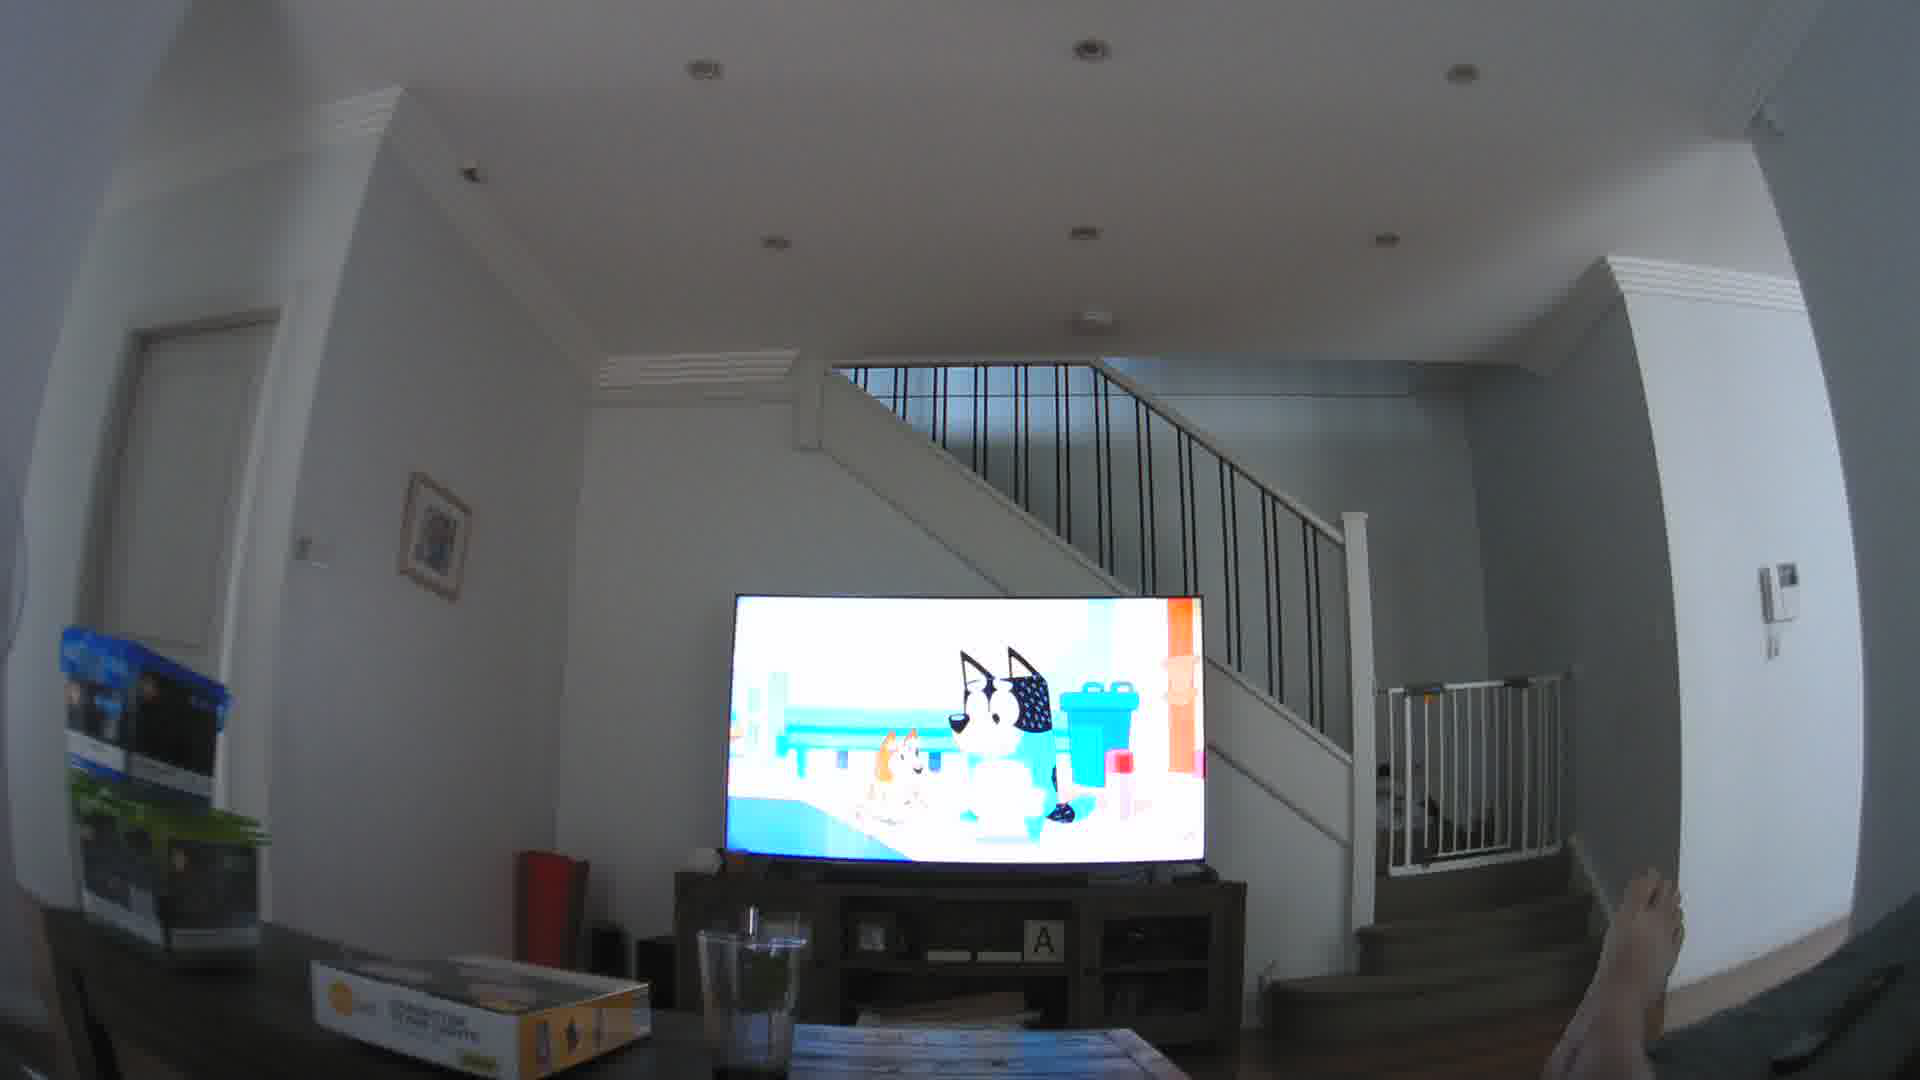

In [3]:
example_image = "../docs/imgs/examples/pre-partial-block.jpg"

Image.open(example_image)

In [4]:
predictions = predictor.predict(example_image)
example_prediction = next(predictions)

/home/tasanders/miniconda3/envs/square_eyes/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


The predictor returns a python generator, where each element is a set of predictions for an image. Even images that have no predictions will be returned, so you can assume that the number of predictions is the same as the number of images.

We've grabbed the first (/only) prediction from the generator to show how the predictions are structured.

There's a couple of elements you'll likely want to use:

`prediction.names` is a list of the class names. These are the things that the model has been trained to detect. Not all of them are screens - some are meant to indicate that there is likely a screen nearby. So, you might want to filter out predictions you don't care about

In [5]:
example_prediction.names

{0: 'Desktop Computer',
 1: 'Computer Monitor',
 2: 'Laptop Computer',
 3: 'Mobile Phone',
 4: 'iPod',
 5: 'Tablet',
 6: 'Television',
 7: 'Computer Mouse',
 8: 'Computer Keyboard',
 9: 'Remote',
 10: 'Handheld game console'}

`prediction.plot()` lets you plot the predictions on top of the image. It will include the bounding box (green box below), the class name, and the confidence (on a scale of 0 - 1).

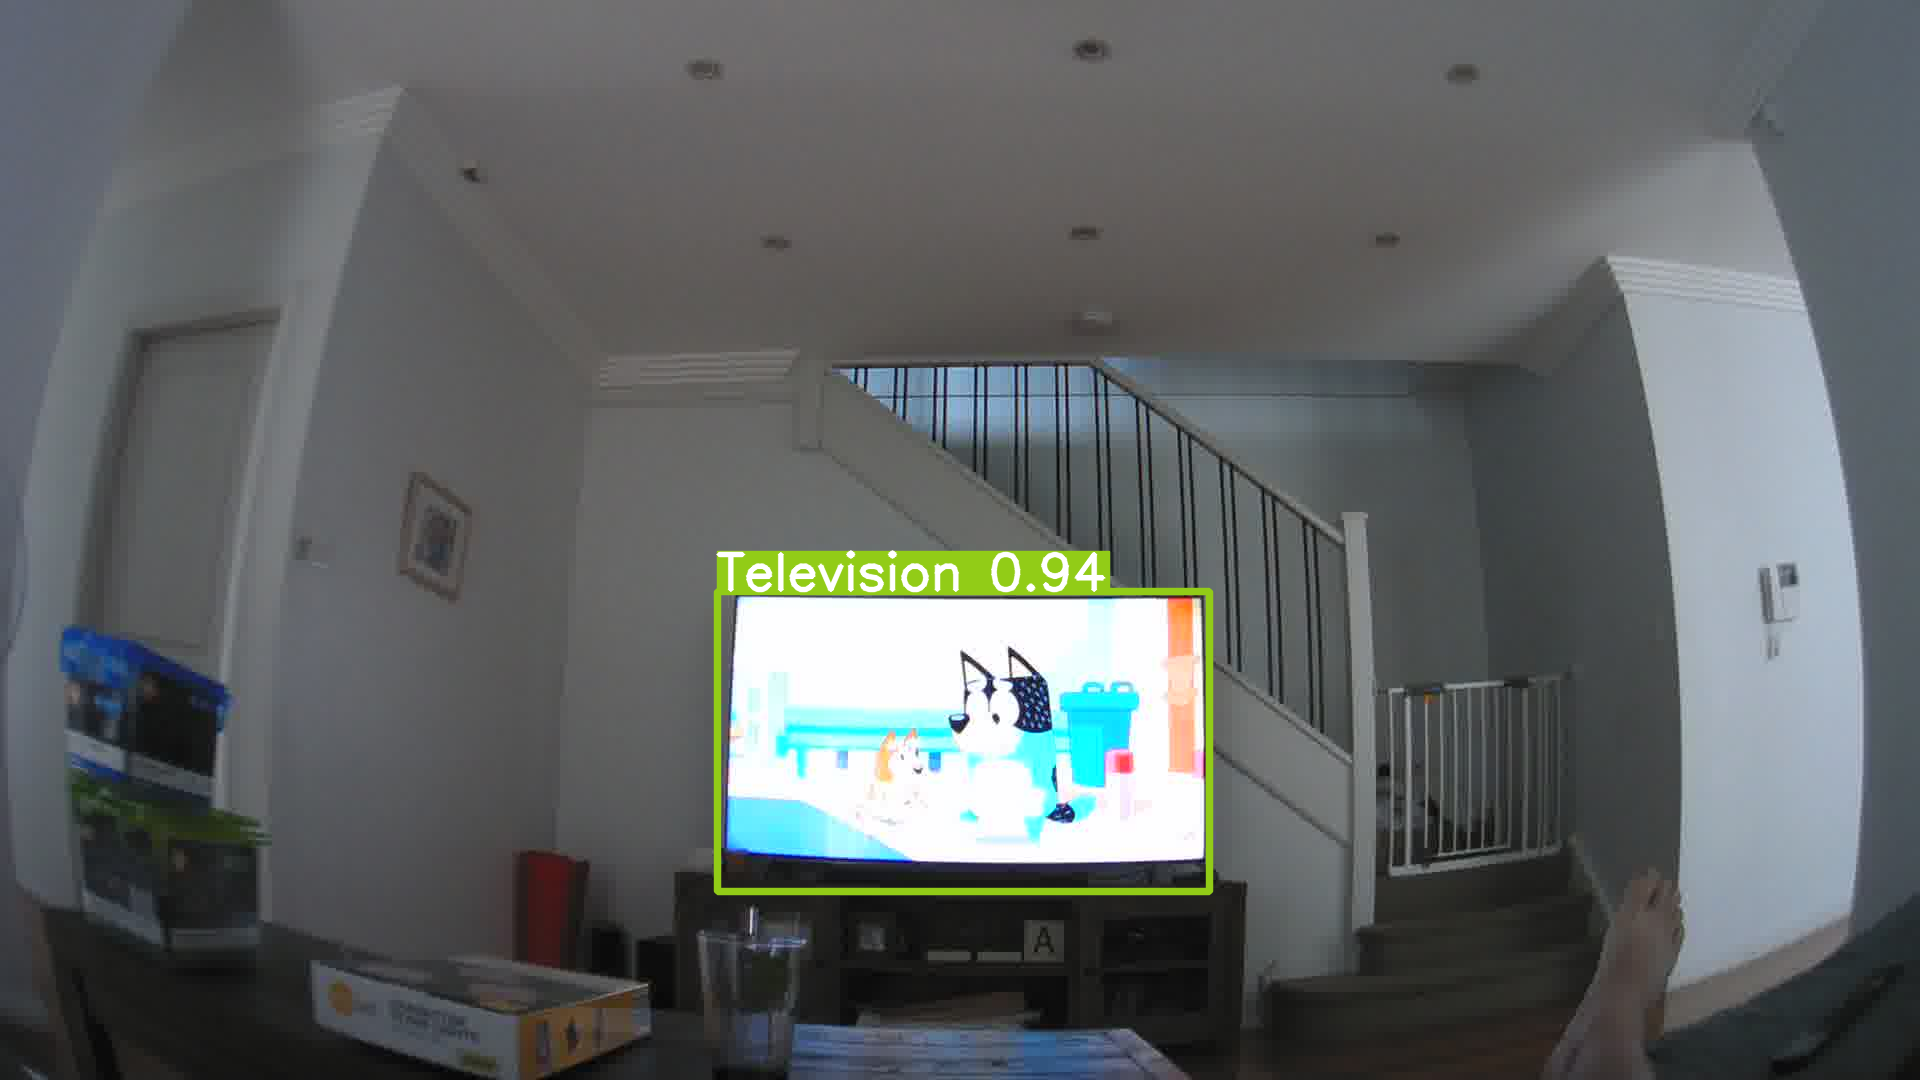

In [6]:
Image.fromarray(example_prediction.plot()[..., ::-1])

A couple of others that are handy are:
* `prediction.orig_shape` which gives you the image dimensions
* `prediction.path` which gives you the path to the image
* `prediction.speed` which gives the time it took to generate this prediction

In [7]:
print(example_prediction.orig_shape)
print(example_prediction.path)
print(example_prediction.speed)

(1080, 1920)
/home/tasanders/GitHub/SquareEyes/notebooks/../docs/imgs/examples/pre-partial-block.jpg
{'preprocess': 2.7196407318115234, 'inference': 116.78814888000488, 'postprocess': 1.3766288757324219}


The main thing you'll want to interact with though is the bounding boxes, which contain the information about each prediction.

`prediction.boxes` is a list of the bounding boxes (the area of the image the model thinks contains something of interest). Because it is a list, you need to remember to interact with each element in the list rather than the list itself.

Below I get the first bounding box. In practice, you won't always know how many bounding boxes there are (and there can be zero), so it's safer to loop through them. I'll show how to do that later.

In [8]:
example_bbox = example_prediction.boxes[0]
example_bbox

WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.


ultralytics.engine.results.Boxes object with attributes:

boxes: tensor([[7.1702e+02, 5.9139e+02, 1.2098e+03, 8.9114e+02, 9.4280e-01, 6.0000e+00]], device='cuda:0')
cls: tensor([6.], device='cuda:0')
conf: tensor([0.9428], device='cuda:0')
data: tensor([[7.1702e+02, 5.9139e+02, 1.2098e+03, 8.9114e+02, 9.4280e-01, 6.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (1080, 1920)
shape: torch.Size([1, 6])
xywh: tensor([[963.4142, 741.2654, 492.7911, 299.7559]], device='cuda:0')
xywhn: tensor([[0.5018, 0.6864, 0.2567, 0.2776]], device='cuda:0')
xyxy: tensor([[ 717.0186,  591.3875, 1209.8097,  891.1434]], device='cuda:0')
xyxyn: tensor([[0.3734, 0.5476, 0.6301, 0.8251]], device='cuda:0')

Lots to unpack here.

`boxes` is a list of the coordinates of the bounding boxes. Why is it a list if there is only ever one? I have no idea.

`cls` is the class of the prediction. This links back to `prediction.names` above. In this case, it is class 6, which is "Television".

`conf` is the confidence of the prediction. This is a number between 0 and 1, where 1 is the model is very confident that this is a screen. You can use this to filter out predictions based on how confident you want to be that it is a screen.

`xyxy`/`xywh` are coordinates for the bounding boxes in various different formats. `xyxy` are the top left and bottom right corners. `xywh` is the center point of the image (`x` and `y`) along with the width and height (`w` and `h`). `xyxyn`/`xywhn` are the same, but normalised to the image size (so the top left corner is 0,0 and the bottom right corner is 1,1). I usually work with the width and height.

Here's an example of working with each of these:

In [9]:
class_id = int(example_bbox.cls)
class_name = example_prediction.names[class_id]
conf = float(example_bbox.conf)
x_1, y_1, x_2, y_2 = example_bbox.xyxy[0]

print(
    f"The prediction is for a {class_name} (class {class_id}) with confidence score {conf:.2f}. \nThe region is bounded by the coordinates ({x_1:.2f}, {y_1:.2f}) and ({x_2:.2f}, {y_2:.2f})."
)

The prediction is for a Television (class 6) with confidence score 0.94. 
The region is bounded by the coordinates (717.02, 591.39) and (1209.81, 891.14).


Once you have these values, you can do with them whatever you want. For example, write them to a csv file along with the image path and the confidence.

## Predicting on a folder of images

It's much more likely that you'll want to predict on a whole folder of images at once. This is much faster than doing them one at a time. The process is largely the same, so below I also show how to loop through the predictions. If you're using the Timelapse software, a lot of this isn't necessary - there are functions built-in to do this for you. These will eventually be documented in the model docs.

I'm not going to print all the images here, so you might want to take a look at the folder to see what the files look like. Also, these are very easy predictions for the model, so it's not a great example of how it performs on harder images.

In [10]:
example_folder = "../docs/imgs/examples"

Predicting on a folder is very similar to predicting on a single image. You can pass just the folder path into the predictor.

In [11]:
predictions = predictor.predict(example_folder)

Let's imagine our goal is to create a csv file that has the image path, the class(es), and the confidence score(s). We only want to include predictions that are above 0.2 confidence, and we'll convert the 'device-indicators' into just a binary flag. Here's how that might look: 

In [12]:
# Create an empty list to store the csv rows
csv_rows = []

# Loop through the predictions
for prediction in predictions:
    mappings = prediction.names
    image_path = prediction.path
    out_row = {  # This is what each csv row will look like
        "Image": os.path.basename(image_path),  # Image file name
        "Device1": "",  # Device type
        "Device1_conf": "",  # Confidence score
        "Device2": "",
        "Device2_conf": "",
        "DeviceNum": "",  # Number of devices in the image
        "NonScreenIndicators": "FALSE",
    }

    device_n = 1
    for box in prediction.boxes:
        label = mappings[int(box.cls)]
        if label in [
            "Desktop Computer",
            "Computer Mouse",
            "Computer Keyboard",
            "Remote",
        ]:
            out_row["NonScreenIndicators"] = "TRUE"
        elif box.conf > 0.25:
            out_row[f"Device{device_n}"] = label
            out_row[f"Device{device_n}_conf"] = float(box.conf)
            out_row["DeviceNum"] = device_n
            device_n += 1

        if device_n > 2:
            # Assume there are no more than 3 devices in an image
            break
    csv_rows.append(out_row)

We could then save `csv_rows` as a csv file. I'm just going to print it so you can see what it looks like:

In [13]:
pd.DataFrame(csv_rows)

,Image,Device1,Device1_conf,Device2,Device2_conf,DeviceNum,NonScreenIndicators
0,blocked.jpg,,,,,,FALSE
1,blurry.jpg,,,,,,FALSE
2,ceiling.jpg,,,,,,FALSE
3,fully-blocked.jpg,,,,,,FALSE
4,inactive-device.jpg,,,,,,FALSE
5,overexposed.jpg,,,,,,FALSE
6,partial-block.jpg,Television,0.251161,,,1,FALSE
7,post-ceiling.jpg,Television,0.987227,,,1,FALSE
8,post-fully-blocked.jpg,,,,,,FALSE
9,post-partial-block.jpg,Television,0.848809,,,1,FALSE


The model did OK here - it managed to skip the computer monitor when it was switched off (in image 'inactive-device'), and it even managed to identify the TV in 'partial-block' even though most of the television isn't visible. But it also misclassified the TV in 'pre-fully-blocked' as a computer monitor, and it missed the TV in 'post-fully-blocked' (probably because of the motion blur). If you turn the confidence down it does get detected, so it's worth playing around with this setting.

In [16]:
example_image = "../docs/imgs/examples/post-fully-blocked.jpg"
predictions = predictor.predict(example_image, conf=0.1)
example_prediction = next(predictions)
example_prediction.boxes[0]

WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.


ultralytics.engine.results.Boxes object with attributes:

boxes: tensor([[4.5861e+02, 4.7043e+02, 1.0624e+03, 9.8433e+02, 1.9848e-01, 3.0000e+00]], device='cuda:0')
cls: tensor([3.], device='cuda:0')
conf: tensor([0.1985], device='cuda:0')
data: tensor([[4.5861e+02, 4.7043e+02, 1.0624e+03, 9.8433e+02, 1.9848e-01, 3.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (1080, 1920)
shape: torch.Size([1, 6])
xywh: tensor([[760.4980, 727.3763, 603.7723, 513.8992]], device='cuda:0')
xywhn: tensor([[0.3961, 0.6735, 0.3145, 0.4758]], device='cuda:0')
xyxy: tensor([[ 458.6118,  470.4267, 1062.3842,  984.3259]], device='cuda:0')
xyxyn: tensor([[0.2389, 0.4356, 0.5533, 0.9114]], device='cuda:0')

## Extracting Timestamps

This is not related to the model, but I thought it might be useful to show how you can extract timestamps from the images. 

This works by extracting the section of the image that contains the timestamp, inverting the colours and increasing the contrast, and then using OCR to extract the text. The location of the timestamp is hardcoded to work only with our TLC130 cameras, but it could also be adapted to other cameras that print timestamps on the image.

In [15]:
timestamped_image = "../docs/imgs/examples/timestamped.jpg"
timestamp = extract_timestamps([timestamped_image])

print(
    f"The timestamp in image {os.path.basename(timestamped_image)} is {timestamp[os.path.basename(timestamped_image)]}"
)

The timestamp in image timestamped.jpg is 2021-12-01 16:02:43
